# 3. Cluster analysis

General info may be found in the following blogposts:  
https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/  
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/  
https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019  
https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318  

## Q&A

### Remark
Not sure if GJ said to use clr or pca for clustering, pca was used here as example. --> **clr data, see next remark**

### Response 10/04/2020 16:10
Retrieved some notes I made when GJ explained how to use the cluster analysis but we will have to ask him to elaborate on this on Tuesday:

"Cluster analyse met permutatie (cfr simulaties bij ons interpolatie project; coördinaten koppelen aan andere metadata) en telkens nieuw dendrogram maken. Daarna cumulative density function van statistische (euclidische?) afstand maken en 95% als threshold gebruiken om kritieke afstand te bepalen waarop groepen significant zijn. + wegingsfactor voor coördinaten meegeven (tussen 0 en 1)"

To answer your questions below I have added responses to them in-line

### Questions + remarks

-Cophenetic correlation coefficient has to be close to 1, from which value its okay?  
**Good question, honestly I don't think it matters that much as some of the blog posts don't mention it at all. Another reason to not pay to much attention to it is by using e.g. the 'ward' method vs. the 'centroid' method. The latter might give a better cophenetic correlation that the former but the resulting figure of the 'ward' method looks more sensible in my opinion.**

-Changed number of clusters from 5 to 4 in the code "cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')". Seemed to be the right choice when looking to the dendrogram.  
**This is something where you will have to make a choice indeed, both options can be defended**

-A lot of methods were given to define the number of cluster goups, the best way was to to this by hand (the largest vertical distance where horizontal lines doesn't intersect other newclusters). howerver, the dendogram already subdivided 4 clusters. I know that there are methods to do this automatically, are they used here? Or does python automatically created the groups based on the first method mentioned?  
**The first dendrogram is used to visually check how many clusters you want to use in the actual clustering step (AgglomerativeClustering). This decision is thus made by using the horizontal line trick but there should be a way to automate this but would have to look into this mayself more. GJ's comment above might point us in the right direction but need to work out the code to do it, or find code to do it.**

-Which data of the PCA is taken into account? Are all the principal components taken into account? Or only two because the examples I saw focussed on two variables. i will certainly look into it, so i will probably find out how this will be done using all the Princiel components if that is the case   
**All PCs were used, but this is irrelevant now as from GJ's comment it's clear that we have to use the clr data. We could ask GJ why we use clr instead of PCA because the possiblity of dimensionality reduction with PCA prior to the clustering might be interesting? But I'm note sure if this would be mathematically correct let alone sensible.**

-It is clear for me which cluster method is used and which linkage method and why it is used.   
**OK**


**remark**
not sure how to visualise the treshhold of 95%, but i will look to it after the biplots

## Code

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering

In [2]:
import prepostprocessing.pre_processing as preproc

In [3]:
pca_df_area1 = preproc.load_obj("mineralogy_pca_area1_df")
metadata_area1 = preproc.load_obj("metadata_area1")

pca_df_area2 = preproc.load_obj("mineralogy_pca_area2_df")
metadata_area2 = preproc.load_obj("metadata_area2")

pca_df_area3 = preproc.load_obj("mineralogy_pca_area3_df")
metadata_area3 = preproc.load_obj("metadata_area3")

pca_df_area4 = preproc.load_obj("mineralogy_pca_area4_df")
metadata_area4 = preproc.load_obj("metadata_area4")

pca_df_area5 = preproc.load_obj("mineralogy_pca_area5_df")
metadata_area5 = preproc.load_obj("metadata_area5")

pca_df = preproc.load_obj("mineralogy_pca_df1")
metadata = preproc.load_obj("metadata")

mineralogy_clr = preproc.load_obj("mineralogy_clr1")

In [4]:
area_numbers = pd.read_excel("../_INTERPOLATION/area_subdivided.xlsx", index_col=0, usecols=[0, 24, 29])
#area_numbers = pd.read_excel("../_INTERPOLATION/area1.xlsx", index_col=None, usecols=[0, 24, 29])

In [5]:
pca_df1 = pca_df.iloc[:, 0: 7]

In [6]:
pca_df1

,PC01,PC02,PC03,PC04,PC05,PC06,PC07
1,-0.989677,0.063658,-1.077309,0.949276,0.196830,-1.052766,-0.196021
2,-1.170683,0.906362,-0.457936,0.315585,0.836318,0.547351,-0.165217
3,-1.952305,1.084163,0.126341,-0.059648,0.787068,-1.028997,-0.907513
4,-1.265500,-0.665278,0.792680,1.554351,0.290969,0.026927,-0.145361
5,-1.401423,0.090158,0.667637,-0.203788,-1.529623,-1.127234,-0.414450
...,...,...,...,...,...,...,...
4655,1.969576,-1.154415,0.734286,0.877843,-0.311676,-0.413926,0.060452
4656,2.765959,-0.679754,0.061989,-0.052525,-0.149849,-0.699663,0.034609
4657,2.610638,-1.211222,0.315811,0.056660,-0.001314,-0.147221,-0.224187
4658,2.415960,-0.786335,0.173592,-0.202025,-0.649209,-0.020704,0.652916


In [7]:
metadata

,type_granite,time,massif,sampler,others,sampler+year
1,Granite leucogranitic,K,NaN,NaN,NaN,"V.N.Musin,1970"
2,Granite leucocratic,Tr,NaN,V.I.Zhigalova,NaN,"E.A.Ivanov,1969"
3,Granite leucocratic coarse-grained,K,Omsukchan massif,P.M.Bosek,NaN,"O.S.Gracheva,1948"
4,Granite leucocratic,K,Buksandzhin massif,A.Kh.Brovtman,NaN,"A.F.Mikhaylov,1948"
5,Granite-porphyry micropegmatitic,K,Attykveem massif,L.G.Semenova,0th.:S-0.16,"A.I.Sadovsky,1963"
...,...,...,...,...,...,...
4655,Diorite,K,Egdegkych massif,NaN,Oth.:co2-0.12,"V.A.lgnat'ev,1964"
4656,Quartz diorite,K,Verkhneplotnikovsky massif,NaN,NaN,"A.A.Syas'ko,1969"
4657,Diorite,J,NaN,NaN,"Oth.:co2-0.02,so3-0.0l","N.N.Remizov,1967"
4658,Diorite,K,NaN,NaN,NaN,"A.P.Osipov,1966"


### Remark
**The metadata dataframe you use here for the entire dataset is actually the one for area 1.**  
**Note that metadata for samples that fall outside one of the 5 areas are already excluded from 'area_numbers', though.**

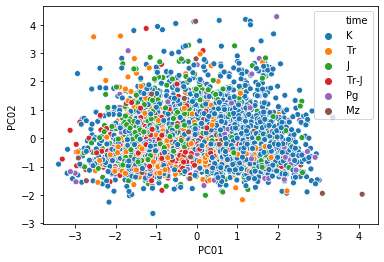

In [8]:
sns.scatterplot(x="PC01", y="PC02", data=pca_df1, hue=metadata["time"])
plt.show();

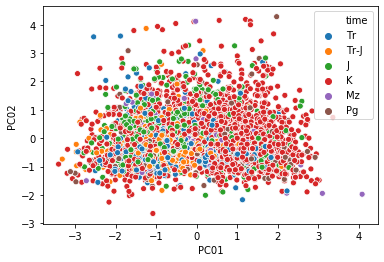

In [9]:
# Scatterplot using time metadata of (almost) entire dataset
sns.scatterplot(x="PC01", y="PC02", data=pca_df1, hue=area_numbers["time"], hue_order=["Tr", "Tr-J", "J", "K", "Mz", "Pg"])
plt.show();

In [10]:
area_numbers[area_numbers["time"] == "K"].index

Int64Index([ 370,  477, 1573,    1,    7,    8,   13,   16,   20,   28,
            ...
            4310, 4317, 4385, 4429, 4516, 4522, 4562, 4594, 4628, 4643],
           dtype='int64', length=2341)

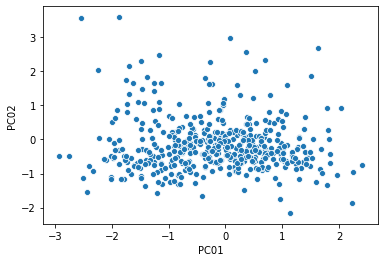

In [11]:
# Quick pot to check if groups are apparent in scatterplot based on time
# classification. Does not seem to be the case, unfortunately.
sns.scatterplot(x="PC01", y="PC02", data=pca_df1.loc[area_numbers[area_numbers["time"] == "Tr"].index, :])
plt.show();

In [12]:
def create_dendrogram(data, linkage_method='ward', save=""):
    """Plot dendrogram
    
    Parameters:
    -----------
    data : array or DataFrame
        Data to be clustered
    linkage_method : str (optional)
        Method to use to construct the linkage matrix
        Choose between ['single', 'complete', 'average',
        'weighted', 'centroid', 'median', 'ward']
        For detailed information see 
        https://docs.scipy.org/doc/scipy-0.14.0/reference/ \
        generated/scipy.cluster.hierarchy.linkage.html
    save : str (optional)
        Name to use for figure file when saving
    """
    
    linkage_matrix = linkage(data, linkage_method)
    c, coph_dists = cophenet(linkage_matrix, pdist(data))
    print("Cophenetic correlation coefficient:", c)
    
    plt.figure(figsize=(25, 10))
    dendrogram(linkage_matrix, labels=data.index)
    if save != "":
        plt.savefig(f"../_FIGURES/{save}.pdf")
    plt.show()

Cophenetic correlation coefficient: 0.4221122031697622


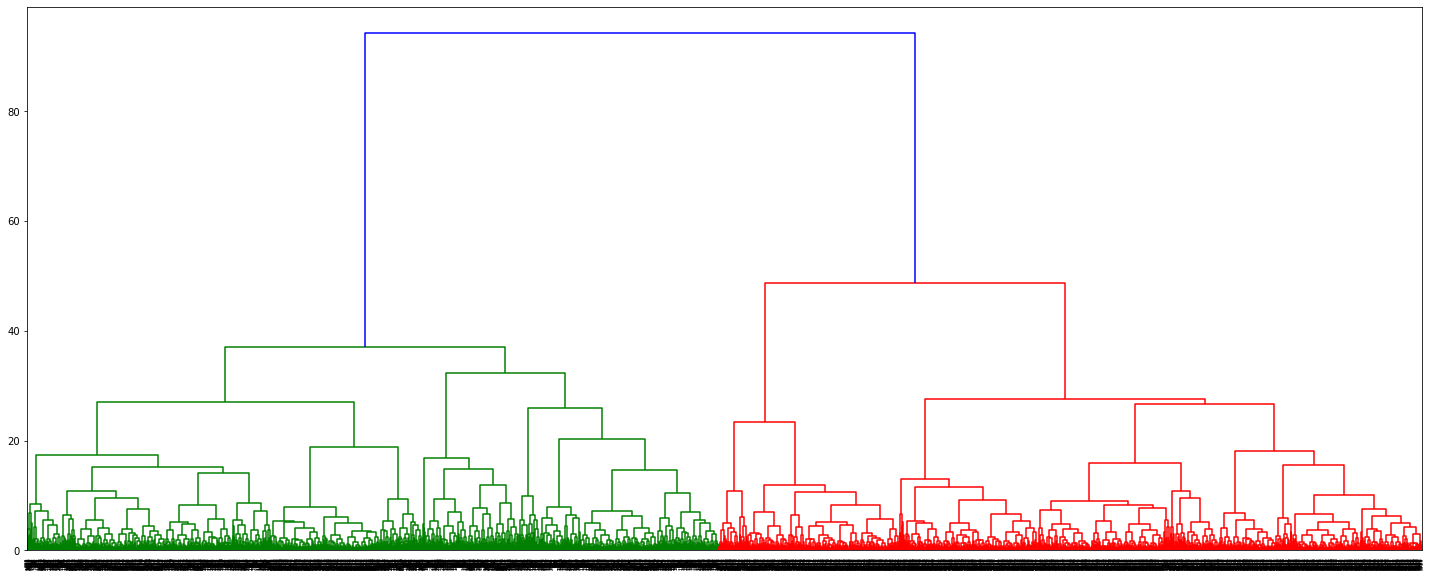

Wall time: 1min 45s


In [13]:
%%time
create_dendrogram(pca_df1, linkage_method='ward')

In [34]:
X = pca_df1.values

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

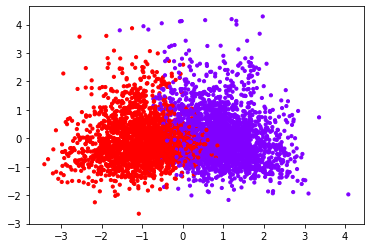

In [35]:
plt.scatter(X[:,0], X[:,1], c=cluster.labels_, cmap='rainbow', s=10)
plt.show();

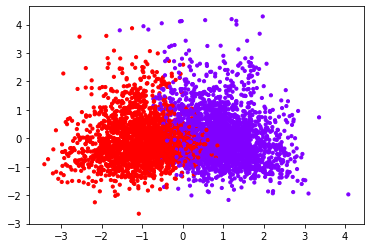

In [36]:
plt.scatter(X[:,0], X[:,1], c=cluster.labels_, cmap='rainbow', s=10)
plt.show();

In [37]:
# You can call the 'labels_' attribute of 'cluster' here instead of 
# performing the 'fit_transform' operation again.
cluster_groups= pd.DataFrame(data=cluster.labels_)

In [38]:
cluster_groups

,0
0,1
1,1
2,1
3,1
4,1
...,...
4654,0
4655,0
4656,0
4657,0


In [39]:
area_numbers = pd.read_excel("../_INTERPOLATION/area_subdivided.xlsx", index_col=0, usecols=[0, 24, 29])
#area_numbers = pd.read_excel("../_INTERPOLATION/area1.xlsx", index_col=None, usecols=[0, 24, 29])

In [40]:
clustering = pd.concat([area_numbers, cluster_groups], axis = 1)
clustering = clustering.dropna()

In [41]:
clustering

,time,area,0
1,K,2.0,1.0
2,Tr,1.0,1.0
3,K,3.0,1.0
4,K,3.0,1.0
5,K,4.0,1.0
...,...,...,...
4653,K,3.0,0.0
4654,K,2.0,0.0
4655,K,4.0,0.0
4656,K,2.0,0.0


In [42]:
clustering.to_excel("../_CLUSTER/groups_time_area/PCA/cluster_control_points.xlsx", index=True)

In [43]:
clustering.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/control_points_count.xlsx")

-----

In [44]:
clustering1= clustering.loc[clustering['area'] == 1]
clustering2= clustering.loc[clustering['area'] == 2]
clustering3= clustering.loc[clustering['area'] == 3]
clustering4= clustering.loc[clustering['area'] == 4]
clustering5= clustering.loc[clustering['area'] == 5]

In [45]:
clustering1_J = clustering1.loc[clustering1['time'] == 'J']
clustering1_Tr = clustering1.loc[clustering1['time'] == 'Tr']
clustering1_Tr_J = clustering1.loc[clustering1['time'] == 'Tr-J']
clustering1_Mz = clustering1.loc[clustering1['time'] == 'Mz']
clustering1_K = clustering1.loc[clustering1['time'] == 'K']

clustering1_J.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area1_J.xlsx")
clustering1_Tr.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area1_Tr.xlsx")
clustering1_Tr_J.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area1_Tr_J.xlsx")
clustering1_Mz.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area1_Mz.xlsx")
clustering1_K.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area1_K.xlsx")

In [46]:
clustering2_J = clustering2.loc[clustering2['time'] == 'J']
clustering2_Tr = clustering2.loc[clustering2['time'] == 'Tr']
clustering2_Pg = clustering2.loc[clustering2['time'] == 'Pg']
clustering2_K = clustering2.loc[clustering2['time'] == 'K']

clustering2_J.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area2_J.xlsx")
clustering2_Tr.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area2_Tr.xlsx")
clustering2_Pg.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area2_Pg.xlsx")
clustering2_K.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area2_K.xlsx")

In [47]:
clustering3_J = clustering3.loc[clustering3['time'] == 'J']
clustering3_Tr = clustering3.loc[clustering3['time'] == 'Tr']
clustering3_Pg = clustering3.loc[clustering3['time'] == 'Pg']
clustering3_K = clustering3.loc[clustering3['time'] == 'K']

clustering3_J.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area3_J.xlsx")
clustering3_Tr.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area3_Tr.xlsx")
clustering3_Pg.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area3_Pg.xlsx")
clustering3_K.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area3_K.xlsx")

In [48]:
clustering4_J = clustering4.loc[clustering4['time'] == 'J']
clustering4_Mz = clustering4.loc[clustering4['time'] == 'Mz']
clustering4_Pg = clustering4.loc[clustering4['time'] == 'Pg']
clustering4_K = clustering4.loc[clustering4['time'] == 'K']

clustering4_J.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area4_J.xlsx")
clustering4_Mz.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area4_Mz.xlsx")
clustering4_Pg.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area4_Pg.xlsx")
clustering4_K.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area4_K.xlsx")

In [49]:
clustering5_Mz = clustering5.loc[clustering5['time'] == 'Mz']
clustering5_Pg = clustering5.loc[clustering5['time'] == 'Pg']
clustering5_K = clustering5.loc[clustering5['time'] == 'K']

clustering5_Mz.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area5_Mz.xlsx")
clustering5_Pg.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area5_Pg.xlsx")
clustering5_K.iloc[:, 2].value_counts().to_excel("../_CLUSTER/groups_time_area/PCA/groups_counts_area5_K.xlsx")

----

In [50]:
coordinates = pd.read_excel("../_PETRO/classification_altereddata.xlsx", index_col=0, usecols=[0, 5, 6])
#coordinates = pd.read_excel("../_INTERPOLATION/area5.xlsx", index_col=0, usecols=[0, 5, 6])

In [51]:
cluster_plot = pd.concat([coordinates, clustering], axis=1)
cluster_plot = cluster_plot.dropna()

In [52]:
cluster_plot

,Latitude,Longitude,time,area,0
1,"44°31'30.0""","138°37'30.0""",K,2.0,1.0
2,"54°12'10.0""","119°24'0.0""",Tr,1.0,1.0
3,"62°36'0.0""","155°36'0.0""",K,3.0,1.0
4,"61°35'0.0""","146°2'0.0""",K,3.0,1.0
5,"68°55'0.0""","164°24'0.0""",K,4.0,1.0
...,...,...,...,...,...
4653,"60°27'0.0""","150°1'0.0""",K,3.0,0.0
4654,"46°28'40.0""","136°34'0.0""",K,2.0,0.0
4655,"66°42'0.0""","164°23'0.0""",K,4.0,0.0
4656,"46°56'30.0""","137°5'3.0""",K,2.0,0.0


In [53]:
cluster_plot.to_excel("../_CLUSTER/groups_time_area/PCA/groups_try.xlsx", index=True)